# This notebook will generate the output of the apoptosis model

---
## Apoptosis Model
### Model scope
This model was published by Albeck *et al.* 2008 (https://doi.org/10.1371/journal.pbio.0060299) and modified by Loriaux *et al.* 2013 to include expression and degradation of most chemical species (https://doi.org/10.1371/journal.pcbi.1002901). The key finding of this model is the variable delay switch-like behavior. Scope is shown below:

In [1]:
using DifferentialEquations, DataFrames
using Plots, StatsPlots
using CSV, Tables
using Sundials

In [2]:
#set up where CSV2Julia is
locationOfCSV2Julia="../CSV2JuliaDiffEq-master/csv2model.py"

"../CSV2JuliaDiffEq-master/csv2model.py"

# RIVA

In [3]:
#identify the three CSV sheets that describe the model
reactionsFile="moduleDefinitionFiles/RIVA/reactions.csv"
parametersFile="moduleDefinitionFiles/RIVA/parameters.csv"
rateLawsFile="moduleDefinitionFiles/RIVA/rateLaws.csv"

#build a command to execute csv2julia
location=[locationOfCSV2Julia]
arguments=[reactionsFile, parametersFile, rateLawsFile,"odeApoptosis.jl"]
cmd=`python3 $locationOfCSV2Julia $arguments`

#lets run csv2julia (requires python to be installed)
run(cmd)

#pop the outputs in a modelFiles folder
mkpath("modelFiles/RIVA/")
mv("odeApoptosis.jl","modelFiles/RIVA/odeApoptosis.jl", force=true)
mv("variableNames.jl","modelFiles/RIVA/variableNamesApoptosis.jl", force=true);

Opening moduleDefinitionFiles/Apop_Bcl2_RIVA/rateLaws.csv as rate law file
Opening moduleDefinitionFiles/Apop_Bcl2_RIVA/parameters.csv as parameters file
Opening moduleDefinitionFiles/Apop_Bcl2_RIVA/reactions.csv as reactions file


In [4]:
function initConditionsApop(y0,syms)
   #units: M 
   y0[findfirst(isequal("DIS"),syms)]=0 
   y0[findfirst(isequal("Bid"),syms)]=60000
   y0[findfirst(isequal("Puma"),syms)]=6000 
   y0[findfirst(isequal("Noxa"),syms)]=7200 
   y0[findfirst(isequal("BclxLc"),syms)]=0 #2800
   y0[findfirst(isequal("Bim"),syms)]=7200 
   y0[findfirst(isequal("Bcl2c"),syms)]=20000 
   y0[findfirst(isequal("Mcl1c"),syms)]=2600
   #this is new and will be replaced by cRel control in multiscale modeling
   y0[findfirst(isequal("Bcl2t"),syms)]=92 
   y0[findfirst(isequal("Bax"),syms)]=7200 
   y0[findfirst(isequal("MBak"),syms)]=5000 
   y0[findfirst(isequal("Mito"),syms)]=500000
   y0[findfirst(isequal("Inhib_eff_Bcl2"),syms)]=1
   y0[findfirst(isequal("Inhib_eff_BclxL"),syms)]=1
   y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=1

   return y0
end


initConditionsApop (generic function with 1 method)

In [5]:
include("modelFiles/RIVA/odeApoptosis.jl")
include("modelFiles/RIVA/variableNamesApoptosis.jl")
p=1
maxTimeSS=100.0
maxTimeTC=24*60.0
params=1;

In [6]:
include("utilityFunctions/fixSpecies.jl")
fixSpecies("modelFiles/RIVA/odeApoptosis.jl","modelFiles/RIVA/odeApoptosisFixed.jl",1)

In [7]:
include("modelFiles/RIVA/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=10.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_RIVA.csv",dfss);
print("Steady state found\n")

Have errors with SS code so just using a long TC instead
Steady state found


In [8]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

h (generic function with 1 method)

In [9]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_RIVA.csv",df)

"outputFiles/apoptosis/TC_RIVA01_Bid.csv"

### Bcl2 inhibition

In [10]:
include("modelFiles/RIVA/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=10.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_RIVA.csv",dfss);
print("Steady state found\n")

Have errors with SS code so just using a long TC instead
Steady state found


In [11]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

h (generic function with 1 method)

In [12]:
y0[findfirst(isequal("Inhib_eff_Bcl2"),syms)]=0.5

0.5

In [13]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_Bcl2_05=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_Bcl2_05)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_RIVA_Bcl2_05.csv",df)

"outputFiles/apoptosis/TC_RIVA01_Bid_Bcl2_05.csv"

In [14]:
include("modelFiles/RIVA/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=10.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_RIVA.csv",dfss);
print("Steady state found\n")

Have errors with SS code so just using a long TC instead
Steady state found


In [15]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

h (generic function with 1 method)

In [16]:
y0[findfirst(isequal("Inhib_eff_Bcl2"),syms)]=0.8

0.8

In [17]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_Bcl2_08=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_Bcl2_08)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_RIVA_Bcl2_08.csv",df)

"outputFiles/apoptosis/TC_RIVA01_Bid_Bcl2_08.csv"

### BclxL inhibition

In [18]:
include("modelFiles/RIVA/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=10.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_RIVA_IE.csv",dfss);
print("Steady state found\n")

Have errors with SS code so just using a long TC instead
Steady state found


In [19]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

h (generic function with 1 method)

In [20]:
y0[findfirst(isequal("Inhib_eff_BclxL"),syms)]=0.5

0.5

In [21]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_BclxL_05=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_BclxL_05)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_RIVA_BclxL_05.csv",df)

"outputFiles/apoptosis/TC_RIVA01_Bid_BclxL_05.csv"

In [22]:
include("modelFiles/RIVA/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=10.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_RIVA.csv",dfss);
print("Steady state found\n")

Have errors with SS code so just using a long TC instead
Steady state found


In [23]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

h (generic function with 1 method)

In [24]:
y0[findfirst(isequal("Inhib_eff_BclxL"),syms)]=0.8

0.8

In [25]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_BclxL_08=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_BclxL_08)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_RIVA_BclxL_08.csv",df)

"outputFiles/apoptosis/TC_RIVA01_Bid_BclxL_08.csv"

### Mcl1 inhibition

In [26]:
include("modelFiles/RIVA/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=10.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_RIVA.csv",dfss);
print("Steady state found\n")

Have errors with SS code so just using a long TC instead
Steady state found


In [27]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

h (generic function with 1 method)

In [28]:
y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=0.5

0.5

In [29]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_Mcl1_05=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_Mcl1_05)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_RIVA_Mcl1_05.csv",df)

"outputFiles/apoptosis/TC_RIVA01_Bid_Mcl1_05.csv"

In [30]:
include("modelFiles/RIVA/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=10.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_RIVA.csv",dfss);
print("Steady state found\n")

Have errors with SS code so just using a long TC instead
Steady state found


In [31]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

h (generic function with 1 method)

In [32]:
y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=0.8

0.8

In [33]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_Mcl1_08=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_Mcl1_08)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_RIVA_Mcl1_08.csv",df)

"outputFiles/apoptosis/TC_RIVA01_Bid_Mcl1_08.csv"

In [ ]:
AMito=findfirst(isequal("AMito"),syms)
plot(sol[AMito,:],lw=2,label="WT")

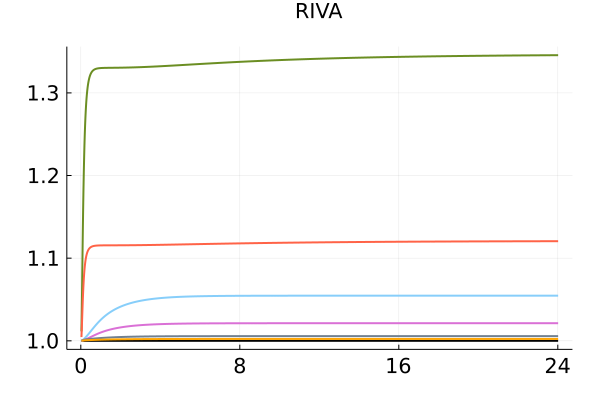

In [34]:
AMito=findfirst(isequal("AMito"),syms)
p1=(plot(sol[AMito,:]./sol[AMito,:],lw=2,linecolor="Black"))#,label="WT"))
plot!(sol_Bcl2_05[AMito,:]./sol[AMito,:],lw=2,linecolor="Olive Drab")#,label="RIVA+ABT-199 (50%)")
plot!(sol_Bcl2_08[AMito,:]./sol[AMito,:],lw=2,linecolor="Tomato")#,label="RIVA+ABT-199 (20%)")
plot!(sol_BclxL_05[AMito,:]./sol[AMito,:],lw=2,linecolor="Light Sky Blue")#,label="RIVA+A1331852 (50%)")
plot!(sol_BclxL_08[AMito,:]./sol[AMito,:],lw=2,linecolor="Orchid")#,label="RIVA+A1331852 (20%)")
plot!(sol_Mcl1_05[AMito,:]./sol[AMito,:],lw=2,linecolor="Slate Gray")#,label="RIVA+S63845 (50%)")
plot!(sol_Mcl1_08[AMito,:]./sol[AMito,:],lw=2,linecolor="Orange")#,label="RIVA+S63845 (20%)")
plot!(#legend=:outerright,
    size=(600,400),margin=5Plots.mm)
s=string.(collect(0:8:24))
plot!(xticks = (0:(60*8):(24*60),s), title = "RIVA", legend = false, #ylabel="MOMP (Fold change)",xlabel="time h", 
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,#legendfontsize=10,
    fmt = :png)
# ,yaxis=:log
# png("outputFiles/apoptosis/RIVA_MOMP")

# U-2932

In [36]:
#identify the three CSV sheets that describe the model
reactionsFile="moduleDefinitionFiles/U2932/reactions.csv"
parametersFile="moduleDefinitionFiles/U2932/parameters.csv"
rateLawsFile="moduleDefinitionFiles/U2932/rateLaws.csv"

#build a command to execute csv2julia
location=[locationOfCSV2Julia]
arguments=[reactionsFile, parametersFile, rateLawsFile,"odeApoptosis.jl"]
cmd=`python3 $locationOfCSV2Julia $arguments`

#lets run csv2julia (requires python to be installed)
run(cmd)

#pop the outputs in a modelFiles folder
mkpath("modelFiles/U2932/")
mv("odeApoptosis.jl","modelFiles/U2932/odeApoptosis.jl", force=true)
mv("variableNames.jl","modelFiles/U2932/variableNamesApoptosis.jl", force=true);

Opening moduleDefinitionFiles/Apop_Bcl2_U2932/rateLaws.csv as rate law file
Opening moduleDefinitionFiles/Apop_Bcl2_U2932/parameters.csv as parameters file
Opening moduleDefinitionFiles/Apop_Bcl2_U2932/reactions.csv as reactions file


In [37]:
function initConditionsApop(y0,syms)
   #units: M
   #source: the supplement of Albeck et al 2008 PLOS Biology
   y0[findfirst(isequal("DIS"),syms)]=0
   y0[findfirst(isequal("Bid"),syms)]=60000
   y0[findfirst(isequal("BclxLc"),syms)]=1000
   y0[findfirst(isequal("Bax"),syms)]=5200
   y0[findfirst(isequal("Mito"),syms)]=500000
   #this is new and will be replaced by cRel control in multiscale modeling
   y0[findfirst(isequal("Bcl2t"),syms)]=92
#    y0[findfirst(isequal("Bim"),syms)]=6000
   y0[findfirst(isequal("Bim"),syms)]=6800 
   y0[findfirst(isequal("Bcl2c"),syms)]=20000
   y0[findfirst(isequal("Mcl1c"),syms)]=10200 
   y0[findfirst(isequal("Puma"),syms)]=2200
   y0[findfirst(isequal("Noxa"),syms)]=15800
   y0[findfirst(isequal("MBak"),syms)]=3400 
   y0[findfirst(isequal("Inhib_eff_Bcl2"),syms)]=1
   y0[findfirst(isequal("Inhib_eff_BclxL"),syms)]=1
   y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=1 

   return y0
end

initConditionsApop (generic function with 1 method)

In [38]:
include("modelFiles/U2932/odeApoptosis.jl")
include("modelFiles/U2932/variableNamesApoptosis.jl")
p=1
maxTimeSS=10000.0
maxTimeTC=24*60.0
params=1;

In [39]:
include("utilityFunctions/fixSpecies.jl")
fixSpecies("modelFiles/U2932/odeApoptosis.jl","modelFiles/U2932/odeApoptosisFixed.jl",1)

In [40]:
include("modelFiles/U2932/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_U2932.csv",dfss);
print("Steady state found\n")

Have errors with SS code so just using a long TC instead
Steady state found


In [41]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

h (generic function with 1 method)

In [42]:
newInit=y0
newInit[1]=y0[1]+1000

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_U2932.csv",df)

"outputFiles/apoptosis/timecourse_U293201_Bid.csv"

### Bcl2 inhibition

In [43]:
include("modelFiles/U2932/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_U2932.csv",dfss);
print("Steady state found\n")

Have errors with SS code so just using a long TC instead
Steady state found


In [44]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

h (generic function with 1 method)

In [45]:
y0[findfirst(isequal("Inhib_eff_Bcl2"),syms)]=0.5

0.5

In [46]:
newInit=y0
newInit[1]=y0[1]+1000

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_Bcl2_05=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_Bcl2_05)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_U2932_Bcl2_05.csv",df)

"outputFiles/apoptosis/TC_U293201_Bid_Bcl2_05.csv"

In [47]:
include("modelFiles/U2932/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_U2932.csv",dfss);
print("Steady state found\n")

Have errors with SS code so just using a long TC instead
Steady state found


In [48]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

h (generic function with 1 method)

In [49]:
y0[findfirst(isequal("Inhib_eff_Bcl2"),syms)]=0.8

0.8

In [50]:
newInit=y0
newInit[1]=y0[1]+1000

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_Bcl2_08=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_Bcl2_08)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_U2932_Bcl2_08.csv",df)

"outputFiles/apoptosis/TC_U293201_Bid_Bcl2_08.csv"

### BclxL inhibition

In [51]:
include("modelFiles/U2932/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_U2932.csv",dfss);
print("Steady state found\n")

Have errors with SS code so just using a long TC instead
Steady state found


In [52]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

h (generic function with 1 method)

In [53]:
y0[findfirst(isequal("Inhib_eff_BclxL"),syms)]=0.5

0.5

In [54]:
newInit=y0
newInit[1]=y0[1]+1000

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_BclxL_05=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_BclxL_05)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_U2932_BclxL_05.csv",df)

"outputFiles/apoptosis/TC_U293201_Bid_BclxL_05.csv"

In [55]:
include("modelFiles/U2932/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_U2932.csv",dfss);
print("Steady state found\n")

Have errors with SS code so just using a long TC instead
Steady state found


In [56]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

h (generic function with 1 method)

In [57]:
y0[findfirst(isequal("Inhib_eff_BclxL"),syms)]=0.8

0.8

In [58]:
newInit=y0
newInit[1]=y0[1]+1000

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_BclxL_08=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_BclxL_08)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_U2932_BclxL_08.csv",df)

"outputFiles/apoptosis/TC_U293201_Bid_BclxL_08.csv"

### Mcl1 inhibition

In [59]:
include("modelFiles/U2932/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_U2932.csv",dfss);
print("Steady state found\n")

Have errors with SS code so just using a long TC instead
Steady state found


In [60]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

h (generic function with 1 method)

In [61]:
y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=0.5

0.5

In [62]:
newInit=y0
newInit[1]=y0[1]+1000

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_Mcl1_05=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_Mcl1_05)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_U2932_Mcl1_05.csv",df)

"outputFiles/apoptosis/TC_U293201_Bid_Mcl1_05.csv"

In [63]:
include("modelFiles/U2932/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_U2932.csv",dfss);
print("Steady state found\n")

Have errors with SS code so just using a long TC instead
Steady state found


In [64]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

h (generic function with 1 method)

In [65]:
y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=0.8

0.8

In [66]:
newInit=y0
newInit[1]=y0[1]+1000

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_Mcl1_08=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_Mcl1_08)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_U2932_Mcl1_08.csv",df)

"outputFiles/apoptosis/TC_U293201_Bid_Mcl1_08.csv"

In [ ]:
AMito=findfirst(isequal("AMito"),syms)
plot(sol[AMito,:],lw=2,label="WT")

In [ ]:
sol[AMito,end]

In [69]:
AMito=findfirst(isequal("AMito"),syms)
p2=(plot(sol[AMito,:]./sol[AMito,:],lw=2,linecolor="Black",label="WT"))
plot!(sol_Bcl2_05[AMito,:]./sol[AMito,:],lw=2,linecolor="Olive Drab",label="Bcl-2 (50%)")
plot!(sol_Bcl2_08[AMito,:]./sol[AMito,:],lw=2,linecolor="Tomato",label="Bcl-2 (20%)")
plot!(sol_BclxL_05[AMito,:]./sol[AMito,:],lw=2,linecolor="Light Sky Blue",label="Bcl-xL (50%)")
plot!(sol_BclxL_08[AMito,:]./sol[AMito,:],lw=2,linecolor="Orchid",label="Bcl-xL (20%)")
plot!(sol_Mcl1_05[AMito,:]./sol[AMito,:],lw=2,linecolor="Slate Gray",label="Mcl1 (50%)")
plot!(sol_Mcl1_08[AMito,:]./sol[AMito,:],lw=2,linecolor="Orange",label="Mcl1 (20%)")
plot!(legend=:outerright,
    size=(800,400),margin=5Plots.mm)
s=string.(collect(0:8:24))
plot!(xticks = (0:(60*8):(24*60),s), ylabel="MOMP (Fold change)",xlabel="time h", 
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,legendfontsize=14,
    fmt = :png)
# png("outputFiles/apoptosis/U2932_MOMP")

# RC-K8

In [ ]:
#identify the three CSV sheets that describe the model
reactionsFile="moduleDefinitionFiles/RCK8/reactions.csv"
parametersFile="moduleDefinitionFiles/RCK8/parameters.csv"
rateLawsFile="moduleDefinitionFiles/RCK8/rateLaws.csv"

#build a command to execute csv2julia
location=[locationOfCSV2Julia]
arguments=[reactionsFile, parametersFile, rateLawsFile,"odeApoptosis.jl"]
cmd=`python3 $locationOfCSV2Julia $arguments`

#lets run csv2julia (requires python to be installed)
run(cmd)

#pop the outputs in a modelFiles folder
mkpath("modelFiles/RCK8/")
mv("odeApoptosis.jl","modelFiles/RCK8/odeApoptosis.jl", force=true)
mv("variableNames.jl","modelFiles/RCK8/variableNamesApoptosis.jl", force=true);

In [ ]:
function initConditionsApop(y0,syms)
   #units: M 
   y0[findfirst(isequal("DIS"),syms)]=0
   y0[findfirst(isequal("Bid"),syms)]=60000
   y0[findfirst(isequal("Puma"),syms)]=3600 
   y0[findfirst(isequal("Noxa"),syms)]=1800 
   y0[findfirst(isequal("BclxLc"),syms)]=20000
   y0[findfirst(isequal("Bim"),syms)]=2000 
   y0[findfirst(isequal("Mcl1c"),syms)]=5000
   y0[findfirst(isequal("A1c"),syms)]=1600
   y0[findfirst(isequal("Bcl2c"),syms)]=1400
   #this is new and will be replaced by cRel control in multiscale modeling
   y0[findfirst(isequal("Bcl2t"),syms)]=69 
   y0[findfirst(isequal("Bax"),syms)]=14200 
   y0[findfirst(isequal("MBak"),syms)]=4600 
   y0[findfirst(isequal("Mito"),syms)]=500000 
   y0[findfirst(isequal("Inhib_eff_Bcl2"),syms)]=1
   y0[findfirst(isequal("Inhib_eff_BclxL"),syms)]=1
   y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=1 

   return y0
end


In [ ]:
include("modelFiles/RCK8/odeApoptosis.jl")
include("modelFiles/RCK8/variableNamesApoptosis.jl")
p=1
maxTimeSS=10000.0
maxTimeTC=24*60.0
params=1;

In [ ]:
include("utilityFunctions/fixSpecies.jl")
fixSpecies("modelFiles/RCK8/odeApoptosis.jl","modelFiles/RCK8/odeApoptosisFixed.jl",1)

In [ ]:
include("modelFiles/RCK8/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_RCK8.csv",dfss);
print("Steady state found\n")

In [ ]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

In [ ]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_RCK8.csv",df)

### Bcl2 inhibition

In [ ]:
include("modelFiles/RCK8/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_RCK8.csv",dfss);
print("Steady state found\n")

In [ ]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

In [ ]:
y0[findfirst(isequal("Inhib_eff_Bcl2"),syms)]=0.5

In [ ]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_Bcl2_05=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_Bcl2_05)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_RCK8_Bcl2_05.csv",df)

In [ ]:
include("modelFiles/RCK8/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_RCK8.csv",dfss);
print("Steady state found\n")

In [ ]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

In [ ]:
y0[findfirst(isequal("Inhib_eff_Bcl2"),syms)]=0.8

In [ ]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_Bcl2_08=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_Bcl2_08)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_RCK8_Bcl2_08.csv",df)

### BclxL inhibition

In [ ]:
include("modelFiles/RCK8/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_RCK8.csv",dfss);
print("Steady state found\n")

In [ ]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

In [ ]:
y0[findfirst(isequal("Inhib_eff_BclxL"),syms)]=0.5

In [ ]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_BclxL_05=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_BclxL_05)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_RCK8_BclxL_05.csv",df)

In [ ]:
include("modelFiles/RCK8/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_RCK8.csv",dfss);
print("Steady state found\n")

In [ ]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

In [ ]:
y0[findfirst(isequal("Inhib_eff_BclxL"),syms)]=0.8

In [ ]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_BclxL_08=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_BclxL_08)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_RCK8_BclxL_08.csv",df)

### Mcl1 inhibition

In [ ]:
include("modelFiles/RCK8/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_RCK8.csv",dfss);
print("Steady state found\n")

In [ ]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

In [ ]:
y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=0.5

In [ ]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_Mcl1_05=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_Mcl1_05)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_RCK80_Mcl1_05.csv",df)

In [ ]:
include("modelFiles/RCK8/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_RCK8.csv",dfss);
print("Steady state found\n")

In [ ]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

In [ ]:
y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=0.8

In [ ]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_Mcl1_08=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_Mcl1_08)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_RCK8_Mcl1_08.csv",df)

In [ ]:
AMito=findfirst(isequal("AMito"),syms)
plot(sol[AMito,:],lw=2,label="WT")

In [ ]:
sol[AMito,end]

In [ ]:
AMito=findfirst(isequal("AMito"),syms)
p3=(plot(sol[AMito,:]./sol[AMito,:],lw=2,linecolor="Black",label="WT"))
plot!(sol_Bcl2_05[AMito,:]./sol[AMito,:],lw=2,linecolor="Olive Drab",label="RCK8+ABT-199 (50%)")
plot!(sol_Bcl2_08[AMito,:]./sol[AMito,:],lw=2,linecolor="Tomato",label="RCK8+ABT-199 (20%)")
plot!(sol_BclxL_05[AMito,:]./sol[AMito,:],lw=2,linecolor="Light Sky Blue",label="RCK8+A1331852 (50%)")
plot!(sol_BclxL_08[AMito,:]./sol[AMito,:],lw=2,linecolor="Orchid",label="RCK8+A1331852 (20%)")
plot!(sol_Mcl1_05[AMito,:]./sol[AMito,:],lw=2,linecolor="Slate Gray",label="RCK8+S63845 (50%)")
plot!(sol_Mcl1_08[AMito,:]./sol[AMito,:],lw=2,linecolor="Orange",label="RCK8+S63845 (20%)")
plot!(legend=:outerright,
    size=(800,400),margin=5Plots.mm)
s=string.(collect(0:8:24))
plot!(xticks = (0:(60*8):(24*60),s), title = "RC-K8", ylabel="MOMP (Fold change)",xlabel="time h", 
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,#legendfontsize=10,
    fmt = :png)
# png("outputFiles/apoptosis/RCK8_MOMP")

# SUDHL8

In [ ]:
#identify the three CSV sheets that describe the model
reactionsFile="moduleDefinitionFiles/SUDHL8/reactions.csv"
parametersFile="moduleDefinitionFiles/SUDHL8/parameters.csv"
rateLawsFile="moduleDefinitionFiles/SUDHL8/rateLaws.csv"

#build a command to execute csv2julia
location=[locationOfCSV2Julia]
arguments=[reactionsFile, parametersFile, rateLawsFile,"odeApoptosis.jl"]
cmd=`python $locationOfCSV2Julia $arguments`

#lets run csv2julia (requires python to be installed)
run(cmd)

#pop the outputs in a modelFiles folder
mkpath("modelFiles/SUDHL8/")
mv("odeApoptosis.jl","modelFiles/SUDHL8/odeApoptosis.jl", force=true)
mv("variableNames.jl","modelFiles/SUDHL8/variableNamesApoptosis.jl", force=true);

In [ ]:
function initConditionsApop(y0,syms)
   #units: M
   #source: the supplement of Albeck et al 2008 PLOS Biology
   y0[findfirst(isequal("DIS"),syms)]=0
   y0[findfirst(isequal("Bid"),syms)]=60000
   y0[findfirst(isequal("BclxLc"),syms)]=20000
   y0[findfirst(isequal("Bax"),syms)]=22000
   y0[findfirst(isequal("Mito"),syms)]=500000
   #this is new and will be replaced by cRel control in multiscale modeling
   y0[findfirst(isequal("Bcl2t"),syms)]=92
   y0[findfirst(isequal("A1c"),syms)]=1600 
#    y0[findfirst(isequal("Bim"),syms)]=6000
   y0[findfirst(isequal("Bim"),syms)]=6000 
   y0[findfirst(isequal("Mcl1c"),syms)]=10400 
   y0[findfirst(isequal("Puma"),syms)]=1600
   y0[findfirst(isequal("MBak"),syms)]=9400 
   y0[findfirst(isequal("Inhib_eff_BclxL"),syms)]=1
   y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=1 

   return y0
end

In [ ]:
include("modelFiles/SUDHL8/odeApoptosis.jl")
include("modelFiles/SUDHL8/variableNamesApoptosis.jl")
p=1
maxTimeSS=10000.0
maxTimeTC=24*60.0
params=1;

In [ ]:
include("utilityFunctions/fixSpecies.jl")
fixSpecies("modelFiles/SUDHL8/odeApoptosis.jl","modelFiles/SUDHL8/odeApoptosisFixed.jl",1)

In [ ]:
include("modelFiles/SUDHL8/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16,maxiters=1e9)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_SUDHL8.csv",dfss);
print("Steady state found\n")

In [ ]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

In [ ]:
newInit=y0
newInit[1]=y0[1]+100

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_SUDHL8.csv",df)

### BclxL inhibition

In [ ]:
include("modelFiles/SUDHL8/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16,maxiters=1e9)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_SUDHL8.csv",dfss);
print("Steady state found\n")

In [ ]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

In [ ]:
y0[findfirst(isequal("Inhib_eff_BclxL"),syms)]=0.5

In [ ]:
newInit=y0
newInit[1]=y0[1]+100

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_BclxL_05=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_BclxL_05)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_SUDHL8_BclxL_05.csv",df)

In [ ]:
include("modelFiles/SUDHL8/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16,maxiters=1e9)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SUDHL8.csv",dfss);
print("Steady state found\n")

In [ ]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

In [ ]:
y0[findfirst(isequal("Inhib_eff_BclxL"),syms)]=0.8

In [ ]:
newInit=y0
newInit[1]=y0[1]+100

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_BclxL_08=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_BclxL_08)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_SUDHL8_BclxL_08.csv",df)

### Mcl1 inihibition 

In [ ]:
include("modelFiles/SUDHL8/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16,maxiters=1e9)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_SUDHL8.csv",dfss);
print("Steady state found\n")

In [ ]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

In [ ]:
y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=0.5

In [ ]:
newInit=y0
newInit[1]=y0[1]+100

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_Mcl1_05=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_Mcl1_05)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_SUDHL8_Mcl1_05.csv",df)

In [ ]:
include("modelFiles/SUDHL8/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16,maxiters=1e9)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_SUDHL8.csv",dfss);
print("Steady state found\n")

In [ ]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

In [ ]:
y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=0.8

In [ ]:
newInit=y0
newInit[1]=y0[1]+100

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_Mcl1_08=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_Mcl1_08)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_SUDHL8_Mcl1_08.csv",df)

In [ ]:
AMito=findfirst(isequal("AMito"),syms)
plot(sol[AMito,:],lw=2,label="WT")

In [ ]:
sol[AMito,end]

In [ ]:
AMito=findfirst(isequal("AMito"),syms)
p4=(plot(sol[AMito,:]./sol[AMito,:],lw=2,linecolor="Black"))#,label="WT"))
plot!(sol_BclxL_05[AMito,:]./sol[AMito,:],lw=2,linecolor="Light Sky Blue")#,label="SUDHL8+A1331852 (50%)")
plot!(sol_BclxL_08[AMito,:]./sol[AMito,:],lw=2,linecolor="Orchid")#,label="SUDHL8+A1331852 (20%)")
plot!(sol_Mcl1_05[AMito,:]./sol[AMito,:],lw=2,linecolor="Slate Gray")#,label="SUDHL8+S63845 (50%)")
plot!(sol_Mcl1_08[AMito,:]./sol[AMito,:],lw=2,linecolor="Orange")#,label="SUDHL8+S63845 (20%)")
plot!(#legend=:outerright,
    size=(600,400),margin=5Plots.mm)
s=string.(collect(0:8:24))
plot!(xticks = (0:(60*8):(24*60),s), title = "SUDHL8", legend = false, #ylabel="MOMP (Fold change)",xlabel="time h", 
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,#legendfontsize=10,
    fmt = :png)
# png("outputFiles/apoptosis/SUDHL8_MOMP")

# SUDHL10

In [ ]:
#identify the three CSV sheets that describe the model
reactionsFile="moduleDefinitionFiles/SUDHL10/reactions.csv"
parametersFile="moduleDefinitionFiles/SUDHL10/parameters.csv"
rateLawsFile="moduleDefinitionFiles/SUDHL10/rateLaws.csv"

#build a command to execute csv2julia
location=[locationOfCSV2Julia]
arguments=[reactionsFile, parametersFile, rateLawsFile,"odeApoptosis.jl"]
cmd=`python $locationOfCSV2Julia $arguments`

#lets run csv2julia (requires python to be installed)
run(cmd)

#pop the outputs in a modelFiles folder
mkpath("modelFiles/SUDHL10/")
mv("odeApoptosis.jl","modelFiles/SUDHL10/odeApoptosis.jl", force=true)
mv("variableNames.jl","modelFiles/SUDHL10/variableNamesApoptosis.jl", force=true);

In [ ]:
function initConditionsApop(y0,syms)
   #units: M
   #source: the supplement of Albeck et al 2008 PLOS Biology
   y0[findfirst(isequal("DIS"),syms)]=0 
   y0[findfirst(isequal("Bid"),syms)]=60000
   y0[findfirst(isequal("Bax"),syms)]=6400
   y0[findfirst(isequal("Mito"),syms)]=500000
   #this is new and will be replaced by cRel control in multiscale modeling
   y0[findfirst(isequal("Bcl2t"),syms)]=277
#    y0[findfirst(isequal("Bim"),syms)]=6000
   y0[findfirst(isequal("Bim"),syms)]=2000
   y0[findfirst(isequal("Mcl1c"),syms)]=20000
   y0[findfirst(isequal("Noxa"),syms)]=12200
   y0[findfirst(isequal("MBak"),syms)]=8400 
   y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=1 

   return y0
end

In [ ]:
include("modelFiles/SUDHL10/odeApoptosis.jl")
include("modelFiles/SUDHL10/variableNamesApoptosis.jl")
p=1
maxTimeSS=10000.0
maxTimeTC=24*60.0
params=1;

In [ ]:
include("utilityFunctions/fixSpecies.jl")
fixSpecies("modelFiles/SUDHL10/odeApoptosis.jl","modelFiles/UDHL10/odeApoptosisFixed.jl",1)

In [ ]:
include("modelFiles/SUDHL10/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
# solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_SUDHL10.csv",dfss);
print("Steady state found\n")

In [ ]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

In [ ]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_SUDHL10.csv",df)

### Mcl1 inhibition

In [ ]:
include("modelFiles/SUDHL10/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
# solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_SUDHL10.csv",dfss);
print("Steady state found\n")

In [ ]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

In [ ]:
y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=0.5

In [ ]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_Mcl1_05=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_Mcl1_05)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_SUDHL10_Mcl1_05.csv",df)

In [ ]:
include("modelFiles/SUDHL10/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
# solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_SUDHL10.csv",dfss);
print("Steady state found\n")

In [ ]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

In [ ]:
y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=0.8

In [ ]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_Mcl1_08=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_Mcl1_08)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_SUDHL10_Mcl1_08.csv",df)

In [ ]:
AMito=findfirst(isequal("AMito"),syms)
plot(sol[AMito,:],lw=2,label="WT")

In [ ]:
sol[AMito,end]

In [ ]:
AMito=findfirst(isequal("AMito"),syms)
p5=(plot(sol[AMito,:]./sol[AMito,:],lw=2,linecolor="Black"))#,label="WT"))
plot!(sol_Mcl1_05[AMito,:]./sol[AMito,:],lw=2,linecolor="Slate Gray")#,label="SUDHL10+S63845 (50%)")
plot!(sol_Mcl1_08[AMito,:]./sol[AMito,:],lw=2,linecolor="Orange")#,label="SUDHL10+S63845 (20%)")
plot!(#legend=:outerright,
    size=(600,400),margin=5Plots.mm)
s=string.(collect(0:8:24))
plot!(xticks = (0:(60*8):(24*60),s), title = "SUDHL10", legend = false, #ylabel="MOMP (Fold change)",xlabel="time h", 
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,#legendfontsize=10,
    fmt = :png)
# png("outputFiles/apoptosis/SUDHL10_MOMP")

# U2946

In [ ]:
#identify the three CSV sheets that describe the model
reactionsFile="moduleDefinitionFiles/U2946/reactions.csv"
parametersFile="moduleDefinitionFiles/U2946/parameters.csv"
rateLawsFile="moduleDefinitionFiles/U2946/rateLaws.csv"

#build a command to execute csv2julia
location=[locationOfCSV2Julia]
arguments=[reactionsFile, parametersFile, rateLawsFile,"odeApoptosis.jl"]
cmd=`python $locationOfCSV2Julia $arguments`

#lets run csv2julia (requires python to be installed)
run(cmd)

#pop the outputs in a modelFiles folder
mkpath("modelFiles/U2946/")
mv("odeApoptosis.jl","modelFiles/U2946/odeApoptosis.jl", force=true)
mv("variableNames.jl","modelFiles/U2946/variableNamesApoptosis.jl", force=true);

In [ ]:
function initConditionsApop(y0,syms)
   #units: M 
   y0[findfirst(isequal("DIS"),syms)]=0
   y0[findfirst(isequal("Bid"),syms)]=60000
   y0[findfirst(isequal("Bax"),syms)]=15200
   y0[findfirst(isequal("Mito"),syms)]=500000
   #this is new and will be replaced by cRel control in multiscale modeling
   y0[findfirst(isequal("Bcl2t"),syms)]=277 
#    y0[findfirst(isequal("Bim"),syms)]=6000
   y0[findfirst(isequal("Bim"),syms)]=13400
   y0[findfirst(isequal("Mcl1c"),syms)]=20000
   y0[findfirst(isequal("Noxa"),syms)]=7800
   y0[findfirst(isequal("MBak"),syms)]=6600 
   y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=1

   return y0
end


In [ ]:
include("modelFiles/U2946/odeApoptosis.jl")
include("modelFiles/U2946/variableNamesApoptosis.jl")
p=1
maxTimeSS=10000.0
maxTimeTC=24*60.0
params=1;

In [ ]:
include("utilityFunctions/fixSpecies.jl")
fixSpecies("modelFiles/U2946/odeApoptosis.jl","modelFiles/U2946/odeApoptosisFixed.jl",1)

In [ ]:
include("modelFiles/U2946/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_U2946.csv",dfss);
print("Steady state found\n")

In [ ]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

In [ ]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_U2946.csv",df)

### Mcl1 inhibition

In [ ]:
include("modelFiles/U2946/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_U2946.csv",dfss);
print("Steady state found\n")

In [ ]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

In [ ]:
y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=0.5

In [ ]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_Mcl1_05=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_Mcl1_05)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_U2946_Mcl1_05.csv",df)

In [ ]:
include("modelFiles/U2946/odeApoptosisFixed.jl")
stringSyms=syms
y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)
syms2=Symbol.(syms)
f=ODEFunction(odeFile!,syms=syms2)

#steady state phase
print("Have errors with SS code so just using a long TC instead\n")
# prob=ODEProblem(f,y0,(0.0,maxTimeSS))
prob=ODEProblem(f,y0,(0.0,10000.0),abstol=1e-16,reltol=1e-16)
solss=solve(prob,saveat=100.0,progress = true,isoutofdomain=(y,p,t)->any(x->x<0,y))
# solss=solve(prob,saveat=100.0,progress = true)

#save the last bit of the SS solution
dfss = DataFrame(solss[end-100:end],:auto)
#add the variable names and save to a file
insertcols!(dfss, 1, :names=>syms2)
mkpath("outputFiles/apoptosis/")
CSV.write("outputFiles/apoptosis/SS_U2946.csv",dfss);
print("Steady state found\n")

In [ ]:
#dynamic phase, use SS solution as initial conditions
y0=vec(convert(Array, dfss[:,end]))
h(p,t)=y0

In [ ]:
y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=0.8

In [ ]:
newInit=y0
newInit[1]=y0[1]+0.01

#we might use this later to remove Bcl2 survival signal
#newInit[end]=2.77
prob=ODEProblem(f,newInit,(0.0,maxTimeTC),abstol=1e-16,reltol=1e-16,maxiters=1e9)
sol_Mcl1_08=solve(prob,saveat=1.0,progress = true)

#lets save this result in a csv file
df=DataFrame(sol_Mcl1_08)
# insertcols!(df, 1, :names=>syms)
CSV.write("outputFiles/apoptosis/TC_U2946_Mcl1_08.csv",df)

In [ ]:
AMito=findfirst(isequal("AMito"),syms)
plot(sol[AMito,:],lw=2,label="WT")

In [ ]:
sol[AMito,end]

In [ ]:
AMito=findfirst(isequal("AMito"),syms)
p6=(plot(sol[AMito,:]./sol[AMito,:],lw=2,linecolor="Black"))#,label="WT"))
plot!(sol_Mcl1_05[AMito,:]./sol[AMito,:],lw=2,linecolor="Slate Gray")#,label="U2946+S63845 (50%)")
plot!(sol_Mcl1_08[AMito,:]./sol[AMito,:],lw=2,linecolor="Orange")#,label="U2946+S63845 (20%)")
plot!(#legend=:outerright,
    size=(600,400),margin=5Plots.mm)
s=string.(collect(0:8:24))
plot!(xticks = (0:(60*8):(24*60),s), title = "U2946", legend = false, #ylabel="MOMP (Fold change)",xlabel="time h", 
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,#legendfontsize=10,
    fmt = :png)
# png("outputFiles/apoptosis/U2946_MOMP")

In [ ]:
plot(p1, p2, p3, p4, p5, p6, layout = (3, 2), size=(800,1200))
plot!(xlabel = "time h", ylabel = "MOMP (Fold change)")
# png("outputFiles/apoptosis/Cells_MOMP_paper")